# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2
from PIL import Image
from skimage.io import imread

import os
import random

In [2]:
from tensorflow.keras import layers, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-08-30 04:59:55.436131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756529995.672454      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756529995.740056      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import warnings
warnings.filterwarnings('ignore')

# 2. Dataset Preparation

## 2-1. Extract Class Names

In [4]:
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

In [5]:
class_names = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

print('Class Names:', class_names)

Class Names: ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']


## 2-2. Extract Image Paths

In [6]:
class_image_paths = {
    'Arborio': [],
    'Basmati': [],
    'Ipsala': [],
    'Jasmine': [],
    'Karacadag': []
}

for class_name in class_names:

    class_dir = f"{data_dir}/{class_name}"
    
    for file in os.listdir(class_dir):
        
        if file.endswith(".png") or file.endswith(".jpg"): 
            class_image_paths[class_name].append(
                os.path.join(class_dir, file)
            )

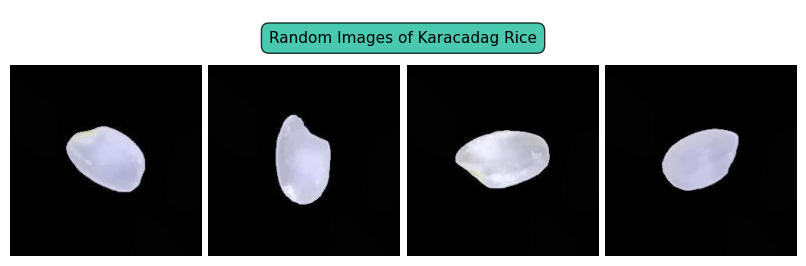

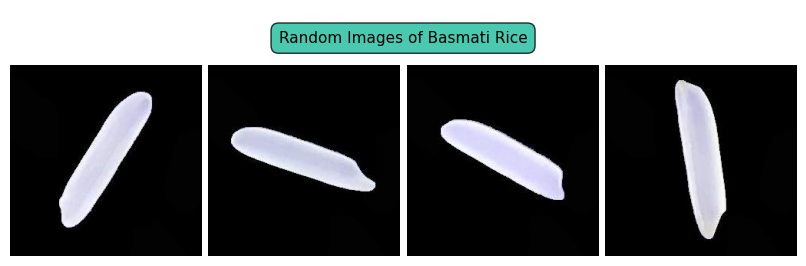

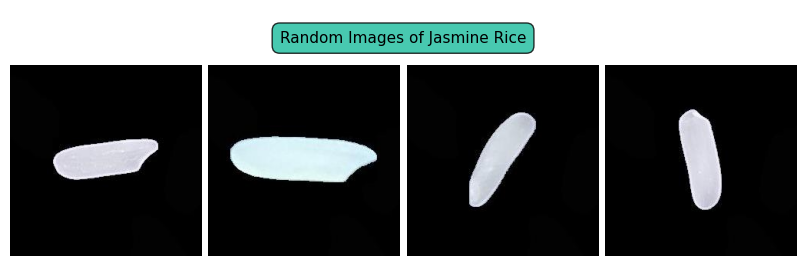

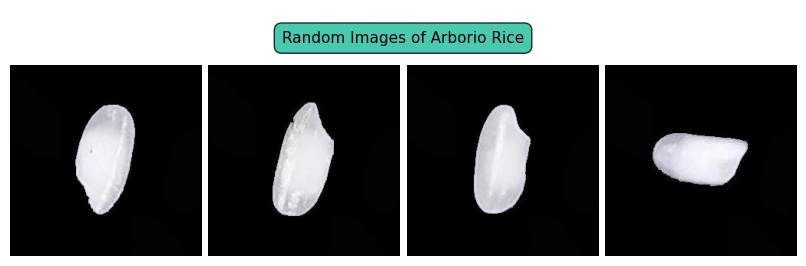

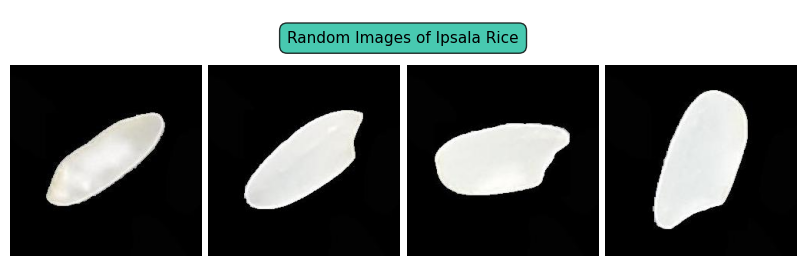

In [7]:
for class_name in class_names:
    fig = plt.figure(figsize=(8, 3))
    gs = gridspec.GridSpec(2, 4, height_ratios=[0.1, 0.95])

    title_ax = fig.add_subplot(gs[0, :])
    title_ax.text(0.5, 0, f"Random Images of {class_name} Rice",
                  fontsize=11, ha='center', va='center',
                  bbox=dict(facecolor='#1ABC9C', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8))
    title_ax.axis('off')

    for j in range(4):
        ax = fig.add_subplot(gs[1, j])
        random_img = random.choice(class_image_paths[class_name])
        img = imread(random_img)
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout(pad=0.5)
    plt.show()

## 2-3. Create DataFrames for Data Generators

In [8]:
print(f"Number of Samples in Classes:")

for class_name in class_names:
    print(f"{class_name:9} = {len(class_image_paths[class_name])}")

Number of Samples in Classes:
Karacadag = 15000
Basmati   = 15000
Jasmine   = 15000
Arborio   = 15000
Ipsala    = 15000


In [9]:
# 75% of the Data
train_df = pd.concat([
    pd.DataFrame({'image': class_image_paths['Arborio'][:11250]  , 'label': 'Arborio'}), 
    pd.DataFrame({'image': class_image_paths['Basmati'][:11250]  , 'label': 'Basmati'}), 
    pd.DataFrame({'image': class_image_paths['Ipsala'][:11250]   , 'label': 'Ipsala'}), 
    pd.DataFrame({'image': class_image_paths['Jasmine'][:11250]  , 'label': 'Jasmine'}), 
    pd.DataFrame({'image': class_image_paths['Karacadag'][:11250], 'label': 'Karacadag'})
])

# 20% of the Data
val_df = pd.concat([
    pd.DataFrame({'image': class_image_paths['Arborio'][11250:14250]  , 'label': 'Arborio'}), 
    pd.DataFrame({'image': class_image_paths['Basmati'][11250:14250]  , 'label': 'Basmati'}), 
    pd.DataFrame({'image': class_image_paths['Ipsala'][11250:14250]   , 'label': 'Ipsala'}), 
    pd.DataFrame({'image': class_image_paths['Jasmine'][11250:14250]  , 'label': 'Jasmine'}), 
    pd.DataFrame({'image': class_image_paths['Karacadag'][11250:14250], 'label': 'Karacadag'})
])

# 5% of the Data
test_df = pd.concat([
    pd.DataFrame({'image': class_image_paths['Arborio'][14250:15000]  , 'label': 'Arborio'}), 
    pd.DataFrame({'image': class_image_paths['Basmati'][14250:15000]  , 'label': 'Basmati'}), 
    pd.DataFrame({'image': class_image_paths['Ipsala'][14250:15000]   , 'label': 'Ipsala'}), 
    pd.DataFrame({'image': class_image_paths['Jasmine'][14250:15000]  , 'label': 'Jasmine'}), 
    pd.DataFrame({'image': class_image_paths['Karacadag'][14250:15000], 'label': 'Karacadag'})
])

In [10]:
print('Number of Train Data:', len(train_df))
print('Number of Validation Data:', len(val_df))
print('Number of Test Data:', len(test_df))

Number of Train Data: 56250
Number of Validation Data: 15000
Number of Test Data: 3750


## 2-4. Create Data Generators

In [11]:
print('Random Image Shapes:')

for i in range(1,6):
    random_img_path = random.choice(random.choice(list(class_image_paths.values())))
    image = cv2.imread(random_img_path)
    print(f'{i}. {image.shape[:2]}')

Random Image Shapes:
1. (250, 250)
2. (250, 250)
3. (250, 250)
4. (250, 250)
5. (250, 250)


In [12]:
img_height, img_width = (250, 250)
batch_size = 128

In [13]:
train_generator = ImageDataGenerator(rescale=1/255)
val_generator   = ImageDataGenerator(rescale=1/255)
test_generator  = ImageDataGenerator(rescale=1/255)

In [14]:
train_data = train_generator.flow_from_dataframe(
    dataframe = train_df,
    class_mode = "categorical",
    x_col = "image",
    y_col = "label",
    batch_size = batch_size,
    seed = 42,
    shuffle = True,
    target_size = (img_height,img_width)
)

val_data = val_generator.flow_from_dataframe(
    dataframe = val_df,
    class_mode = "categorical",
    x_col = "image",
    y_col = "label",
    batch_size = batch_size,
    seed = 42,
    shuffle = True,
    target_size = (img_height,img_width)
)

test_data = test_generator.flow_from_dataframe(
    dataframe = test_df,
    class_mode = "categorical",
    x_col = "image",
    y_col = "label",
    batch_size = batch_size,
    seed = 42,
    shuffle = True,
    target_size = (img_height,img_width)
)

Found 56250 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


# 3. Modeling

## 3-1. Build Model

In [15]:
# The model is based on the AlexNet architecture.

def build_model():
    
    inp = layers.Input(shape=(250, 250, 3))
    
    x = layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=4, strides=1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = layers.Conv2D(filters=384, kernel_size=3, strides=1, activation='relu')(x)
    x = layers.Conv2D(filters=384, kernel_size=3, strides=1, activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, strides=1, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dropout(rate=0.5)(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dropout(rate=0.5)(x)
    
    out = layers.Dense(units=5, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    return model

In [16]:
model = build_model()

model.summary()

I0000 00:00:1756530300.441452      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 60, 60, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 60, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     4,198,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,527,621 (93.57 MB)

 Trainable params: 24,526,917 (93.56 MB)

 Non-trainable params: 704 (2.75 KB)

## 3-2. Model Training

In [17]:
model.compile(
    loss      = BinaryCrossentropy(),
    optimizer = Adam(learning_rate=0.001), 
    metrics   = ['accuracy']
)

In [18]:
history = model.fit(
    train_data, 
    epochs = 2, 
    validation_data = val_data
)

Epoch 1/2


I0000 00:00:1756530309.681592      61 service.cc:148] XLA service 0x7efb70006bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756530309.682766      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756530310.280454      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/440 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.2344 - loss: 4.5268   

I0000 00:00:1756530319.104282      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


440/440 ━━━━━━━━━━━━━━━━━━━━ 609s 1s/step - accuracy: 0.8166 - loss: 0.3626 - val_accuracy: 0.6961 - val_loss: 0.2981
Epoch 2/2
440/440 ━━━━━━━━━━━━━━━━━━━━ 208s 473ms/step - accuracy: 0.9665 - loss: 0.0416 - val_accuracy: 0.9345 - val_loss: 0.0834


## 3-3. Evaluate Model on Test Data

In [19]:
test_loss, test_acc = model.evaluate(test_data)

30/30 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9296 - loss: 0.0840


In [20]:
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9336
Test Loss: 0.0844


## 3-4. Visualization of Model Predictions

In [21]:
sample_images, sample_labels = next(iter(test_data))

images = sample_images[:4]

labels = sample_labels[:4]
preds = model.predict(images)

real_labels = np.argmax(labels, axis=1)
pred_labels = np.argmax(preds, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step


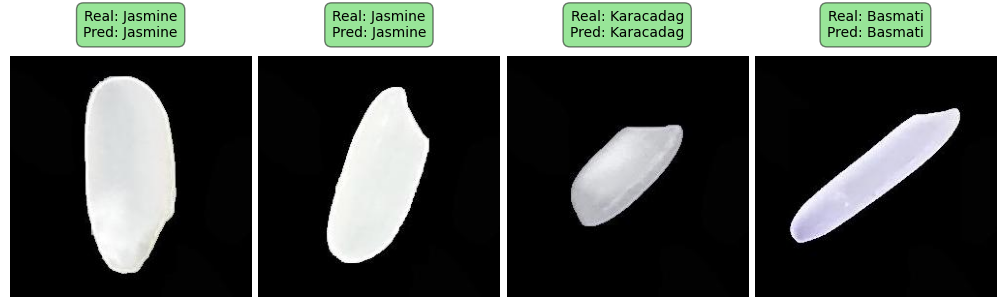

In [22]:
plt.figure(figsize=(10, 3))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    
    real_label = class_names[real_labels[i]]
    pred_label = class_names[pred_labels[i]]
        
    plt.title(
        f"Real: {real_label}\nPred: {pred_label}",
        fontsize=10,
        color='black',
        pad=10,
        y = 1.02,
        bbox=dict(
            boxstyle="round,pad=0.5", 
            facecolor='limegreen' if real_label == pred_label else 'salmon', 
            alpha=0.5
        )
    )

plt.tight_layout(pad=0.5)
plt.show()